In [1]:
#importing all modules and packages used

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn.model_selection as ms
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [2]:
import lasio
las = lasio.read('WLC_PETRO_COMPUTED_INPUT_1.LAS') #.Las file used

Header section Parameter regexp=~P was not found.


In [3]:
df = las.df()  #converting it to a table
df.head()

,CARB_FLAG,COAL_FLAG,DT,GR,NPHI,RD,RHOB,ROP5_RM,RS,RT,SAND_FLAG
DEPTH,,,,,,,,,,,
239.8776,NaN,NaN,NaN,NaN,NaN,0.7766,NaN,98.863197,4.490900,0.1015,NaN
240.0300,NaN,NaN,NaN,NaN,NaN,0.7717,NaN,98.687103,6.752500,0.1000,NaN
240.1824,NaN,NaN,NaN,NaN,NaN,0.7717,NaN,99.039299,6.752500,0.1000,NaN
240.3348,NaN,NaN,NaN,20.866899,NaN,0.4374,NaN,99.760498,12.005200,0.1000,NaN
240.4872,NaN,NaN,NaN,20.984800,NaN,2.3402,NaN,99.748299,139.059204,0.1000,NaN


In [4]:
df["DEPTH"] = df.index   #creating a depth column from table index which is the depth

In [6]:
df.isna().sum()     #checking the missing values in each column

CARB_FLAG    23156
COAL_FLAG    23252
DT           12822
GR               4
NPHI          7836
RD            4634
RHOB         11948
ROP5_RM       4379
RS            4627
RT            4625
SAND_FLAG    23248
DEPTH            0
dtype: int64

In [7]:
df = df.reset_index(drop=True)   #removing the index

In [15]:
def log_plot(logs):
    '''
    Function used for plotting the logs
    '''
    logs = logs.sort_values(by='DEPTH')
    top = logs.DEPTH.min()
    bot = logs.DEPTH.max()
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,8))
    ax[0].plot(logs.RHOB, logs.DEPTH, color='black')
    ax[2].plot(logs.NPHI, logs.DEPTH, color='blue')
    ax[3].plot(np.log(logs.RT), logs.DEPTH, color='c')
    ax[4].plot(logs.SONIC, logs.DEPTH, color='m')
    
    for i in range(len(ax)):
        ax[i].set_ylim(top,bot)
        ax[i].invert_yaxis()
        ax[i].grid()
        
    ax[0].set_xlabel("RHOB")
    ax[0].set_xlim(logs.RHOB.min(),logs.RHOB.max())
    ax[0].set_ylabel("Depth(ft)")
    ax[1].set_xlabel("gr")
    ax[1].set_xlim(0, 150)
    ax[2].set_xlabel("nphi")
    ax[2].set_xlim(logs.NPHI.min(),logs.NPHI.max())
    ax[3].set_xlabel("res")
    ax[3].set_xlim(logs.RT.min(),logs.RT.max())
    ax[4].set_xlabel("sonic")
    ax[4].set_xlim(logs.SONIC.min(),logs.SONIC.max())
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]);
    ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[4].set_yticklabels([]) 
    
    f.suptitle('Well:BOGI WELL 3', fontsize=14,y=0.94)

In [9]:
df1 = df.drop(['CARB_FLAG', 'COAL_FLAG', 'SAND_FLAG'], axis=1)  #dropping some columns from the table
df1 = df1.drop(['RS', 'RD', 'ROP5_RM'], axis=1) 

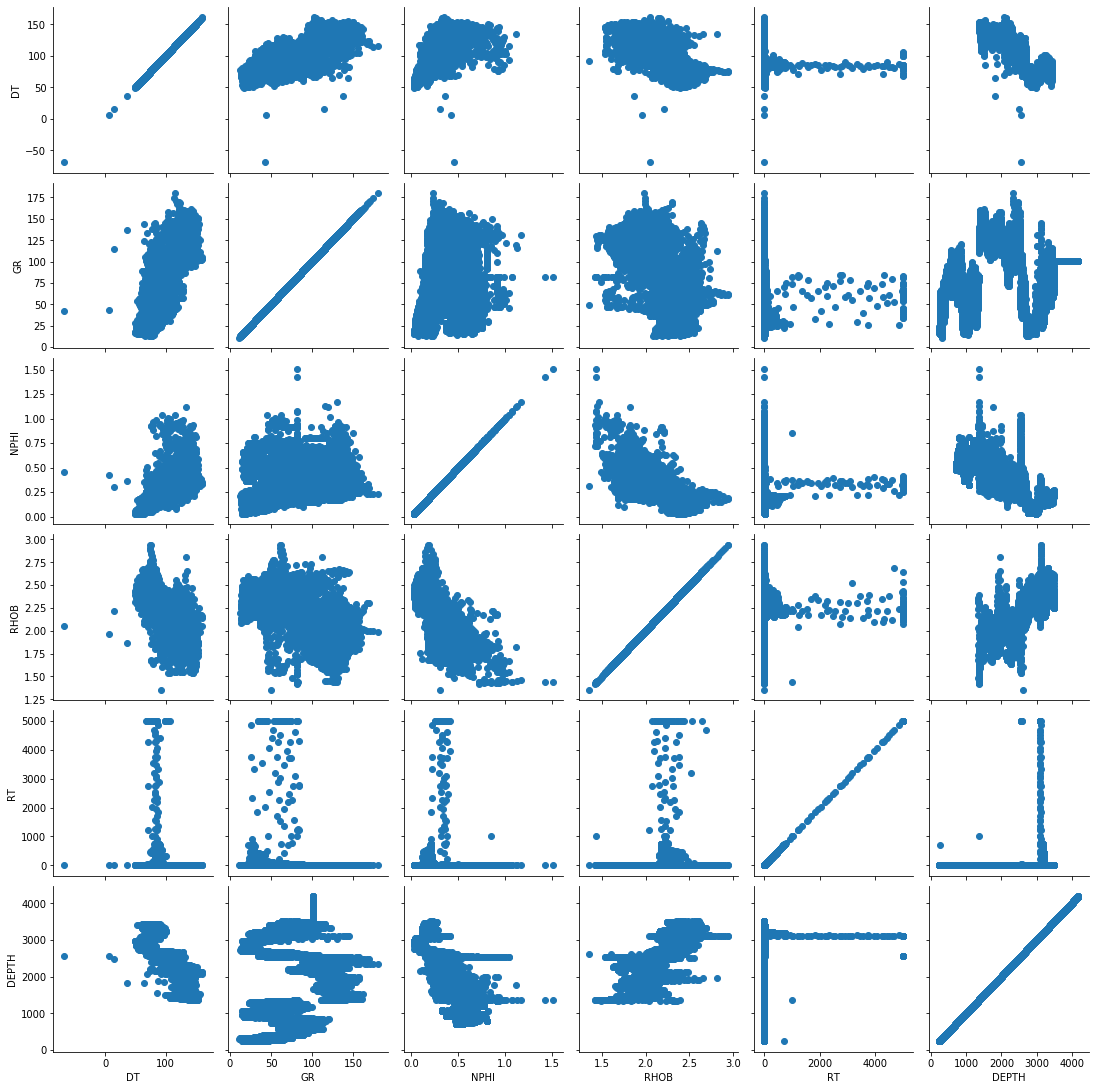

In [10]:
g = sns.PairGrid(df1)
g.map(plt.scatter)

AttributeError: 'DataFrame' object has no attribute 'SONIC'

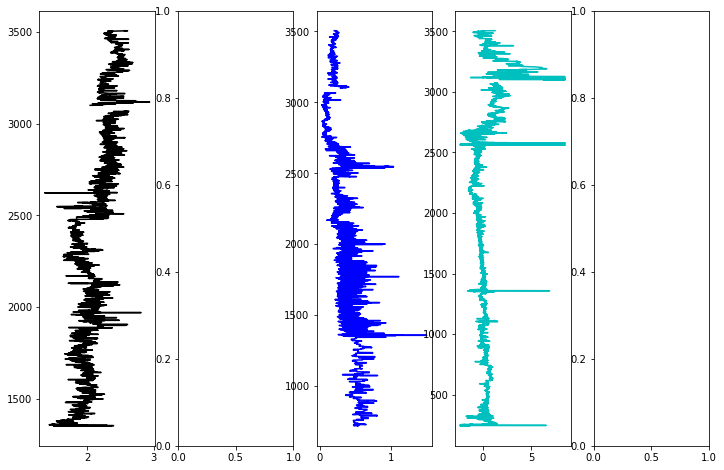

In [16]:
log_plot(df1)

In [17]:
#dividing the dataset into train and test for training and testing the model

train_dt = df1.loc[7409:21017]
test_dt = df1.loc[0:7408]

In [19]:
train_dt = train_dt.dropna()     #dropping missing values in the dataset

In [20]:
train_dt = train_dt.reset_index(drop=True)

DATA PREPARATION

In [21]:
labels_dt = train_dt['DT']   
train_dt = train_dt.drop(['DT'], axis=True)
test_dt = test_dt.drop(['DT'], axis=True)

In [23]:
#converting the data to a numpy array
features_dt = np.array(train_dt)   
test_dt = np.array(test_dt)

In [24]:
## Randomly sample cases to create independent training and test data
np.random.seed(9988)
indx = range(features_dt.shape[0])
indx = ms.train_test_split(indx, test_size = 0.4)
x_train = features_dt[indx[0],:]
y_train = np.ravel(labels_dt[indx[0]])
x_test = features_dt[indx[1],:]
y_test = np.ravel(labels_dt[indx[1]])

In [25]:
## Randomly sample cases to create independent training and test data
np.random.seed(9988)
indx1 = range(x_test.shape[0])
indx1 = ms.train_test_split(indx1, test_size = 0.5)
x_test1 = x_test[indx1[0],:]
y_test1 = np.ravel(y_test[indx1[0]])
x_test2 = x_test[indx1[1],:]
y_test2 = np.ravel(y_test[indx1[1]])

In [26]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7714, 5)
(7714,)
(5144, 5)
(5144,)


In [27]:
print(x_test1.shape)
print(y_test1.shape)
print(x_test2.shape)
print(y_test2.shape)

(2572, 5)
(2572,)
(2572, 5)
(2572,)


In [28]:
#Algorithm used and training process

xg_dt = xgb.XGBRegressor(boosting_type='gbtree', learning_rate=0.01, n_estimators=4000, max_depth=15, base_score=0.7)
eval_set = [(x_test1, y_test1)]
xg_dt.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=200)

[06:28:31] WARNING: /workspace/src/learner.cc:480: 
Parameters: { boosting_type } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:108.24683
Will train until validation_0-rmse hasn't improved in 200 rounds.
[1]	validation_0-rmse:107.16971
[2]	validation_0-rmse:106.10333
[3]	validation_0-rmse:105.04758
[4]	validation_0-rmse:104.00328
[5]	validation_0-rmse:102.96915
[6]	validation_0-rmse:101.94497
[7]	validation_0-rmse:100.93145
[8]	validation_0-rmse:99.92770
[9]	validation_0-rmse:98.93443
[10]	validation_0-rmse:97.95071
[11]	validation_0-rmse:96.97729
[12]	validation_0-rmse:96.01320
[13]	validation_0-rmse:95.05915
[14]	validation_0-rmse:94.11426
[15]	validation_0-rmse:93.17928
[16]	validation_0-rmse:92.25301
[17]	validation_0-rmse:91.33692
[18]	validation_0-r

[240]	validation_0-rmse:11.15929
[241]	validation_0-rmse:11.07101
[242]	validation_0-rmse:10.98416
[243]	validation_0-rmse:10.89864
[244]	validation_0-rmse:10.81442
[245]	validation_0-rmse:10.72972
[246]	validation_0-rmse:10.64675
[247]	validation_0-rmse:10.56440
[248]	validation_0-rmse:10.48338
[249]	validation_0-rmse:10.40303
[250]	validation_0-rmse:10.32298
[251]	validation_0-rmse:10.24461
[252]	validation_0-rmse:10.16735
[253]	validation_0-rmse:10.09032
[254]	validation_0-rmse:10.01477
[255]	validation_0-rmse:9.93943
[256]	validation_0-rmse:9.86469
[257]	validation_0-rmse:9.79139
[258]	validation_0-rmse:9.71867
[259]	validation_0-rmse:9.64681
[260]	validation_0-rmse:9.57620
[261]	validation_0-rmse:9.50647
[262]	validation_0-rmse:9.43760
[263]	validation_0-rmse:9.36921
[264]	validation_0-rmse:9.30245
[265]	validation_0-rmse:9.23642
[266]	validation_0-rmse:9.17073
[267]	validation_0-rmse:9.10564
[268]	validation_0-rmse:9.04285
[269]	validation_0-rmse:8.98021
[270]	validation_0-rmse:8

[496]	validation_0-rmse:4.64376
[497]	validation_0-rmse:4.64147
[498]	validation_0-rmse:4.63944
[499]	validation_0-rmse:4.63710
[500]	validation_0-rmse:4.63534
[501]	validation_0-rmse:4.63311
[502]	validation_0-rmse:4.63144
[503]	validation_0-rmse:4.62923
[504]	validation_0-rmse:4.62768
[505]	validation_0-rmse:4.62557
[506]	validation_0-rmse:4.62375
[507]	validation_0-rmse:4.62175
[508]	validation_0-rmse:4.61919
[509]	validation_0-rmse:4.61745
[510]	validation_0-rmse:4.61544
[511]	validation_0-rmse:4.61344
[512]	validation_0-rmse:4.61161
[513]	validation_0-rmse:4.60993
[514]	validation_0-rmse:4.60831
[515]	validation_0-rmse:4.60681
[516]	validation_0-rmse:4.60511
[517]	validation_0-rmse:4.60280
[518]	validation_0-rmse:4.60064
[519]	validation_0-rmse:4.59859
[520]	validation_0-rmse:4.59708
[521]	validation_0-rmse:4.59572
[522]	validation_0-rmse:4.59438
[523]	validation_0-rmse:4.59306
[524]	validation_0-rmse:4.59182
[525]	validation_0-rmse:4.58990
[526]	validation_0-rmse:4.58852
[527]	va

[753]	validation_0-rmse:4.49617
[754]	validation_0-rmse:4.49608
[755]	validation_0-rmse:4.49602
[756]	validation_0-rmse:4.49597
[757]	validation_0-rmse:4.49608
[758]	validation_0-rmse:4.49609
[759]	validation_0-rmse:4.49602
[760]	validation_0-rmse:4.49583
[761]	validation_0-rmse:4.49569
[762]	validation_0-rmse:4.49566
[763]	validation_0-rmse:4.49557
[764]	validation_0-rmse:4.49565
[765]	validation_0-rmse:4.49550
[766]	validation_0-rmse:4.49563
[767]	validation_0-rmse:4.49540
[768]	validation_0-rmse:4.49530
[769]	validation_0-rmse:4.49525
[770]	validation_0-rmse:4.49510
[771]	validation_0-rmse:4.49506
[772]	validation_0-rmse:4.49485
[773]	validation_0-rmse:4.49503
[774]	validation_0-rmse:4.49522
[775]	validation_0-rmse:4.49518
[776]	validation_0-rmse:4.49497
[777]	validation_0-rmse:4.49472
[778]	validation_0-rmse:4.49476
[779]	validation_0-rmse:4.49485
[780]	validation_0-rmse:4.49506
[781]	validation_0-rmse:4.49528
[782]	validation_0-rmse:4.49508
[783]	validation_0-rmse:4.49530
[784]	va

[1009]	validation_0-rmse:4.48975
[1010]	validation_0-rmse:4.48974
[1011]	validation_0-rmse:4.48959
[1012]	validation_0-rmse:4.48958
[1013]	validation_0-rmse:4.48949
[1014]	validation_0-rmse:4.48944
[1015]	validation_0-rmse:4.48979
[1016]	validation_0-rmse:4.48974
[1017]	validation_0-rmse:4.48983
[1018]	validation_0-rmse:4.48977
[1019]	validation_0-rmse:4.48974
[1020]	validation_0-rmse:4.48972
[1021]	validation_0-rmse:4.48971
[1022]	validation_0-rmse:4.48970
[1023]	validation_0-rmse:4.48965
[1024]	validation_0-rmse:4.48965
[1025]	validation_0-rmse:4.48951
[1026]	validation_0-rmse:4.48946
[1027]	validation_0-rmse:4.48943
[1028]	validation_0-rmse:4.48952
[1029]	validation_0-rmse:4.48950
[1030]	validation_0-rmse:4.48947
[1031]	validation_0-rmse:4.48946
[1032]	validation_0-rmse:4.48931
[1033]	validation_0-rmse:4.48942
[1034]	validation_0-rmse:4.48938
[1035]	validation_0-rmse:4.48933
[1036]	validation_0-rmse:4.48932
[1037]	validation_0-rmse:4.48928
[1038]	validation_0-rmse:4.48924
[1039]	val

[1258]	validation_0-rmse:4.48902
[1259]	validation_0-rmse:4.48903
[1260]	validation_0-rmse:4.48898
[1261]	validation_0-rmse:4.48886
[1262]	validation_0-rmse:4.48883
[1263]	validation_0-rmse:4.48881
[1264]	validation_0-rmse:4.48870
[1265]	validation_0-rmse:4.48866
[1266]	validation_0-rmse:4.48865
[1267]	validation_0-rmse:4.48854
[1268]	validation_0-rmse:4.48850
[1269]	validation_0-rmse:4.48853
[1270]	validation_0-rmse:4.48857
[1271]	validation_0-rmse:4.48846
[1272]	validation_0-rmse:4.48846
[1273]	validation_0-rmse:4.48847
[1274]	validation_0-rmse:4.48870
[1275]	validation_0-rmse:4.48873
[1276]	validation_0-rmse:4.48871
[1277]	validation_0-rmse:4.48861
[1278]	validation_0-rmse:4.48858
[1279]	validation_0-rmse:4.48858
[1280]	validation_0-rmse:4.48853
[1281]	validation_0-rmse:4.48876
[1282]	validation_0-rmse:4.48888
[1283]	validation_0-rmse:4.48881
[1284]	validation_0-rmse:4.48879
[1285]	validation_0-rmse:4.48883
[1286]	validation_0-rmse:4.48882
[1287]	validation_0-rmse:4.48914
[1288]	val

XGBRegressor(base_score=0.7, booster='gbtree', boosting_type='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=4000, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
#evaluating the model performance on the test data

pred_dt = xg_dt.predict(x_test2)

In [30]:
print(f'The RMSE of DT values predicted on the validation data is {mean_squared_error(pred_dt, y_test2) ** 0.5}')

The RMSE of DT values predicted on the validation data is 5.378048034999805


In [31]:
#comparing the actual values to the predicted values

print(y_test2[:20])
print('')
print('')
print(pred_dt[:20])

[ 79.2643966  86.8110961  87.8673019 137.375198  124.357803  132.324401
 124.4971     73.4768981 150.056793  100.889396   96.5238037  71.3046035
 141.213897   91.5615997 142.014007   78.7590026  68.9694976  67.7322006
  81.9328994 128.388504 ]


[ 78.31773   83.56299   88.23972  140.81102  130.40935  133.7299
 125.0374    76.49867  144.8939   100.11653   93.71495   69.748505
 142.1269    95.82709  129.28508   77.77098   62.966015  70.68892
  83.76685  124.84611 ]


In [32]:
#making predictions of the actual missing well log data

missing_pred_dt = xg_dt.predict(test_dt)

In [34]:
df1['DT'].loc[0:7408] = missing_pred_dt

In [36]:
#